# Articulation Robot

Soit une articulation robotique représentée ci-dessous:

<img src="./Images/ArticulationRobot/articulation.png" alt="Image articulation" width=150>

L'articulation est motorisée en son axe de rotation et possède un frottement au sein de l'articulation. Elle possède les caractéristiques suivantes:

- la masse vaut $m=0.36\, \mathrm{kg}$
- la demi-longueur de l'articulation vaut $l=0.451\, \mathrm{m}$
- le coefficient de frottement vaut $b=10$.

On demande ce qui suit:

1. Etablir le modèle d'état non-linéaire du système
2. Linéariser le modèle autour du point de fonctionnement $\theta=45\, ^\circ$ et $\dot{\theta}=0\, \mathrm{rad/s}$
3. Discrétiser le système avec une période d'échantillonnage $h=10\, \mathrm{ms}$
4. Calculer les valeurs propres du système discret et en déduire la stabilité
5. Vérifier la gouvernabilité du système et déterminer la forme canonique de gouvernabilité
6. Vérifier l'observabilité du système et déterminer la forme canonique d'observabilité
7. Ajouter une commande par retour d'état telle que le système devienne 3 fois plus rapide

---

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../my_params.mplstyle')

import numpy as np
import scipy.integrate as spint
import control

1. Etablir le modèle d'état non-linéaire du système

L'équation différentielle est obtenue aisément:

$$ J\frac{d\omega}{dt} = C - b\omega - mgl\sin{\theta} $$

En choisissant $x_1=\theta$, $x_2=\omega$, $u=C$, $y=\theta$, on a:

$$ 
\left\{ \begin{array}{l}
  \dot{x}_1 = x_2 \\
  \dot{x}_2 = -\dfrac{mgl}{J} \sin{x_1} - \dfrac{b}{J}x_2 + \dfrac{1}{J}u \\
  y = x_1
\end{array} \right. 
$$

Le code suivant permet de simuler l'articulation pour un couple donné:

In [2]:
class Articulation:
    def __init__(self, m, l, b):
        self.m = m
        self.l = l
        self.b = b
        
        self.J = m * l ** 2

    def x_prime(self, t, x, u):
        dx1_dt = x[1]
        dx2_dt = (-self.m * self.l * 9.81 * np.sin(x[0]) - self.b * x[1] + u) / self.J 

        return [dx1_dt, dx2_dt]

In [3]:
artic_robot = Articulation(0.36, 0.451, 10)

t_span = (0, 50)
x_init = [0, 0]

t_eval = np.linspace(t_span[0], t_span[1], 10001)

u = 1.12

In [4]:
sol = spint.solve_ivp(artic_robot.x_prime, t_span, x_init, t_eval=t_eval, args=(u,))

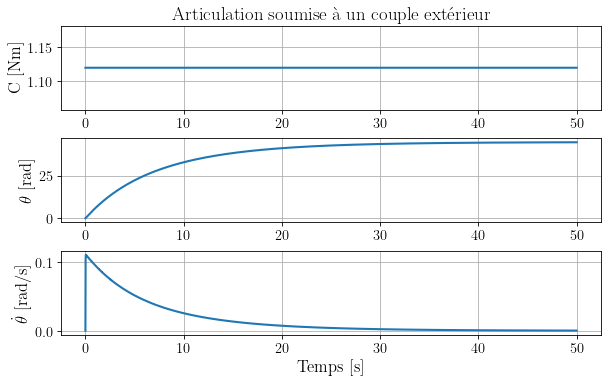

In [5]:
fig, axs = plt.subplots(3, 1, constrained_layout=True)
axs[0].plot(sol.t, [u for _ in sol.t])
axs[1].plot(sol.t, sol.y[0] * 180 / np.pi)
axs[2].plot(sol.t, sol.y[1])
axs[0].set_title('Articulation soumise à un couple extérieur')
axs[0].set_ylabel('C [Nm]')
axs[1].set_ylabel(r'$\theta$ [rad]')
axs[2].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axs[2].set_xlabel('Temps [s]')
axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)

---

2. Linéariser le modèle autour du point de fonctionnement $\theta=45\, ^\circ$ et $\dot{\theta}=0\, \mathrm{rad/s}$

En appliquant la linéarisation, on obtient les dérivées partielles suivantes:

\begin{align}
  &\frac{\partial f_1}{\partial x_1} = 0 \qquad \frac{\partial f_1}{\partial x_2} = 1 \qquad \frac{\partial f_1}{\partial u} = 0 \\
  &\frac{\partial f_2}{\partial x_1} = -\frac{mgl}{J} \cos{\bar{x}_1} \qquad \frac{\partial f_2}{\partial x_2} = -\frac{b}{J} \qquad \frac{\partial f_2}{\partial u} = \frac{1}{J} \\
  &\frac{\partial g}{\partial x_1} = 1 \qquad \frac{\partial g}{\partial x_2} = 0 \qquad \frac{\partial g_1}{\partial u} = 0 \\
\end{align}

On obtient alors le modèle d'état continu linéaire suivant:

$$
\left\{ \begin{array}{l}
  \dot{\mathbf{x}} =
  \left[ \begin{array}{cc}
    0 & 1 \\
    -15.38 & -136.57 \\
  \end{array} \right] \mathbf{x} +
  \left[ \begin{array}{c}
    0 \\
    13.66 \\
  \end{array} \right] u \\
  \mathbf{y} =
  \left[ \begin{array}{cc}
    1 & 0 \\
  \end{array} \right] \mathbf{x} +
  \left[ \begin{array}{c}
    0
  \end{array} \right] u
\end{array} \right.
$$

In [6]:
A = [[0, 1], [-15.38, -136.57]]
B = [[0], [13.66]]
C = [[1, 0]]
D = [[0]]

h = 0.01

ar_lin = control.StateSpace(A, B, C, D)

---

3. Discrétiser le système avec une période d'échantillonnage $h=10\, \mathrm{ms}$

La matrice $\mathbf{F}$ est d'abord calculée par la formule suivante:

$$ \mathbf{F} = \mathrm{e}^{\mathbf{A}h} $$

Une manière de calculer cette matrice serait en exploitant le théorème de Caley-Hamilton.

Tout d'abord, il faut calculer les valeurs propres de $\mathbf{A}$:

\begin{align}
  \det (\lambda \mathbf{I} - \mathbf{A}) &= 
  \det \left( \left[ \begin{array}{cc}
    \lambda & -1 \\
    15.38 & \lambda + 136.57
  \end{array} \right] \right) \\
  &= \lambda^2 + 136.57 \lambda + 15.38 \\
  \Rightarrow &\left\{ \begin{array}{l}
    \lambda_1 = -136.46 \\
    \lambda_2 = -0.1127
  \end{array} \right.
\end{align}

Ensuite, en imposant que $\mathrm{e}^{\lambda_i t}$ soit égal au polynôme $r_0 \lambda_i + r_1$, on trouve les coefficients du polynôme caractéristique de $\mathrm{e}^{\lambda_i t}$:

\begin{align}
  &\left\{ \begin{array}{ll}
    \mathrm{e}^{-136.46t} = -136.46 r_0 + r_1 \\
    \mathrm{e}^{-0.1127t} = -0.1127 r_0 + r_1
  \end{array} \right. \\
  &\left\{ \begin{array}{ll}
    r_1 = \mathrm{e}^{-136.46t} + 136.46 r_0  \\
    \mathrm{e}^{-0.1127t} = -0.1127 r_0 + \mathrm{e}^{-136.46t} + 136.46 r_0
  \end{array} \right. \\
  &\left\{ \begin{array}{ll}
    r_0 = \frac{1}{136.35} (\mathrm{e}^{-0.1127t} - \mathrm{e}^{-136.46t}) \\
    r_1 = \mathrm{e}^{-136.46t} + \frac{136.46}{136.35} (\mathrm{e}^{-0.1127t} - \mathrm{e}^{-136.46t})
  \end{array} \right. \\
\end{align}

Il ne reste plus qu'à évaluer la fonction $\mathrm{e}^{\mathbf{A} t}$:

\begin{align}
  \mathrm{e}^{\mathbf{A} t} &= \frac{1}{136.35} (\mathrm{e}^{-0.1127t} - \mathrm{e}^{-136.46t}) \mathbf{A} + \left( \mathrm{e}^{-136.46t} + \frac{136.46}{136.35} (\mathrm{e}^{-0.1127t} - \mathrm{e}^{-136.46t}) \right) \mathbf{I} \\
  &= \left[ \begin{array}{cc}
    \mathrm{e}^{-136.46t} + \frac{136.46}{136.35} (\mathrm{e}^{-0.1127t} - \mathrm{e}^{-136.46t}) & \frac{1}{136.35} (\mathrm{e}^{-0.1127t} - \mathrm{e}^{-136.46t}) \\
    \frac{-15.38}{136.35} (\mathrm{e}^{-0.1127t} - \mathrm{e}^{-136.46t}) & \frac{-136.57}{136.35} (\mathrm{e}^{-0.1127t} - \mathrm{e}^{-136.46t}) + \mathrm{e}^{-136.46t} + \frac{136.46}{136.35} (\mathrm{e}^{-0.1127t} - \mathrm{e}^{-136.46t})
  \end{array} \right]
\end{align}

En remplaçant $t$ par $h = 10\, \mathrm{ms}$, on obtient:

$$
  \mathbf{F} = \mathrm{e}^{\mathbf{A} h} = \left[ \begin{array}{cc}
    0.9994 & 0.00545 \\
    -0.0839 & 0.2548
  \end{array} \right]
$$

La matrice $\mathbf{G}$ est obtenue par la formule suivante:

$$ \mathbf{G} = \int_{0}^{h} \mathrm{e}^{\mathbf{A}\eta} d\eta \mathbf{B} $$

En reprenant le résultat obtenu précédemment, on a:

\begin{align}
  \mathbf{G} &= \int_{0}^{h} \left[ \begin{array}{cc}
    \mathrm{e}^{-136.46\eta} + \frac{136.46}{136.35} (\mathrm{e}^{-0.1127\eta} - \mathrm{e}^{-136.46\eta}) & \frac{1}{136.35} (\mathrm{e}^{-0.1127\eta} - \mathrm{e}^{-136.46\eta}) \\
    \frac{-15.38}{136.35} (\mathrm{e}^{-0.1127\eta} - \mathrm{e}^{-136.46\eta}) & \frac{-136.57}{136.35} (\mathrm{e}^{-0.1127\eta} - \mathrm{e}^{-136.46\eta}) + \mathrm{e}^{-136.46\eta} + \frac{136.46}{136.35} (\mathrm{e}^{-0.1127\eta} - \mathrm{e}^{-136.46\eta})
  \end{array} \right] \left[ \begin{array}{c}
    0 \\
    13.66
  \end{array} \right] d\eta \\
  &= \left[ \begin{array}{c}
    \frac{0.1}{136.35} (\frac{1}{-0.1127}\mathrm{e}^{-0.1127\eta} - \frac{1}{-136.46}\mathrm{e}^{-136.46\eta}) \\
    \frac{-13.657}{136.35} (\frac{1}{-0.1127}\mathrm{e}^{-0.1127\eta} - \frac{1}{-136.46}\mathrm{e}^{-136.46\eta}) + \frac{0.1}{-136.46}\mathrm{e}^{-136.46\eta} + \frac{13.646}{136.35} (\frac{1}{-0.1127}\mathrm{e}^{-0.1127\eta} - \frac{1}{-136.46}\mathrm{e}^{-136.46\eta})
  \end{array} \right]_0^h \\
  &= \left[ \begin{array}{c}
    4.55*10^{-4} \\
    0.0745
  \end{array} \right]
\end{align}

Le modèle d'état discret devient donc:

$$
\left\{ \begin{array}{l}
  \mathbf{x}(k+1) =
  \left[ \begin{array}{cc}
    0.9994 & 0.00545 \\
    -0.0839 & 0.2548
  \end{array} \right] \mathbf{x}(k) +
  \left[ \begin{array}{c}
    4.55*10^{-4} \\
    0.0745
  \end{array} \right] u(k) \\
  \mathbf{y}(k) =
  \left[ \begin{array}{cc}
    1 & 0
  \end{array} \right] \mathbf{x}(k) +
  \left[ \begin{array}{c}
    0
  \end{array} \right] u(k)
\end{array} \right.
$$

In [7]:
ar_lin_d = control.c2d(ar_lin, h)

print(ar_lin_d)

A = [[ 0.99948806  0.00545224]
 [-0.0838555   0.25487525]]

B = [[0.00045469]
 [0.07447764]]

C = [[1. 0.]]

D = [[0.]]

dt = 0.01



---

4. Calculer les valeurs propres du système discret et en déduire la stabilité

Le calcul des valeurs propres se fait aisément:

\begin{align}
  \det (\lambda \mathbf{I} - \mathbf{F}) &= \left[ \begin{array}{cc}
    \lambda - 0.9994 & -0.00545 \\
    0.0839 & \lambda - 0.2548
  \end{array} \right] \\
  &= (\lambda - 0.9994) (\lambda - 0.2548) + 0.0839 * 0.00545 \\
  &= \lambda^2 - 1.2542 \lambda + 0.2551 \\
  &\Rightarrow \left\{ \begin{array}{l}
    \lambda_1 = 0.9988 \\
    \lambda_2 = 0.2554
  \end{array} \right.
\end{align}

Les valeurs propres étant réelles, positives et inférieures à 1, la conclusion tirée est que le système échantillonné avec une cadence $h=0.01\, \mathrm{s}$ est asymptotiquement stable autour de ce point de fonctionnement pour un couple donné. De plus, la dynamique est asymptotique (non-oscillatoire) et ne possède pas de mode sonnette.

In [8]:
print(np.linalg.eig(ar_lin_d.A)[0])

[0.99887354 0.25548977]


---

5. Vérifier la gouvernabilité du système et déterminer la forme canonique de gouvernabilité

La gouvernabilité du système se vérifie par le rang de la matrice de gouvernabilité donnée par:

\begin{align}
  \mathscr{C} &= \left[ \begin{array}{cc}
    \mathbf{G} & \mathbf{G} \mathbf{F}
  \end{array} \right] \\
  &= \left[ \begin{array}{cc}
    4.55*10^{-4} & 0.0008608 \\
    0.0745 & 0.01894
  \end{array} \right] \\
\end{align}

Il ne reste qu'à vérifier si le rang de cette matrice vaut 2. Pour cela, il suffit de vérifier que son déterminant est différent de 0. Dans le cas contraire, le système n'est pas gouvernable. 

$$ \det{\mathscr{C}} = -5.551 * 10^{-5} \neq 0 $$

Le système est gouvernable.

In [9]:
Com = control.ctrb(ar_lin_d.A, ar_lin_d.B)
print('La matrice de gouvernabilité est: ')
print(Com)
print('Le rang de la matrice C est {}'.format(np.linalg.matrix_rank(Com)))

La matrice de gouvernabilité est: 
[[0.00045469 0.00086052]
 [0.07447764 0.01894438]]
Le rang de la matrice C est 2


Afin d'obtenir la forme canonique commandable, il faut d'abord déterminer la matrice de passage $\mathbf{M}$ telle que $\mathbf{x}(k) = \mathbf{M}^{-1} \mathbf{x}'(k)$.

\begin{align}
  \mathbf{M} = \left[ \begin{array}{c}
    \mathbf{t}_n \\
    \mathbf{t}_n \mathbf{F}
  \end{array} \right] \\
\end{align}

Dans cette expression, $\mathbf{t}_n$ représente la dernière ligne de la matrice $\mathscr{C}^{-1}$.

Les calculs étant assez longs, la suite est effectuée numériquement.

In [10]:
tn = np.linalg.inv(Com)[-1].reshape(2, 1)
M = np.concatenate((tn.T, tn.T @ ar_lin_d.A))

M_inv = np.linalg.inv(M)
F_com = M @ ar_lin_d.A @ M_inv
G_com = M @ ar_lin_d.B
C_com = ar_lin_d.C @ M_inv

ar_lin_g = control.StateSpace(F_com, G_com, C_com, D, h)

print(ar_lin_g)

A = [[ 7.93530848e-17  1.00000000e+00]
 [-2.55201972e-01  1.25436331e+00]]

B = [[1.11022302e-16]
 [1.00000000e+00]]

C = [[0.00029018 0.00045469]]

D = [[0.]]

dt = 0.01



Le modèle d'état sous sa forme canonique gouvernable s'écrit finalement:

$$
\left\{ \begin{array}{l}
  \mathbf{x}'(k+1) =
  \left[ \begin{array}{cc}
    0 & 1 \\
    -0.2552 & 1.2544
  \end{array} \right] \mathbf{x}'(k) +
  \left[ \begin{array}{c}
    0 \\
    1
  \end{array} \right] u(k) \\
  \mathbf{y}(k) =
  \left[ \begin{array}{cc}
    0.00029 & 0.0004547
  \end{array} \right] \mathbf{x}'(k) +
  \left[ \begin{array}{c}
    0
  \end{array} \right] u(k)
\end{array} \right.
$$

In [11]:
print(control.canonical_form(ar_lin_g, 'reachable'))

(A = [[ 1.25436331 -0.25520197]
 [ 1.          0.        ]]

B = [[1.]
 [0.]]

C = [[0.00045469 0.00029018]]

D = [[0.]]

dt = 0.01
, matrix([[ 0.00000000e+00,  1.00000000e+00],
        [ 1.00000000e+00, -1.11022302e-16]]))


---

6. Vérifier l'observabilité du système et déterminer la forme canonique d'observabilité

L'observabilité du système se vérifie par le rang de la matrice d'observabilité donnée par:

\begin{align}
  \mathscr{O} &= \left[ \begin{array}{c}
    \mathbf{C} \\ 
    \mathbf{F} \mathbf{C}
  \end{array} \right] \\
  &= \left[ \begin{array}{cc}
    1 & 0 \\
    0.9994 & 0.00545
  \end{array} \right] \\
\end{align}

Il ne reste qu'à vérifier si le rang de cette matrice vaut 2. Pour cela, il suffit de vérifier que son déterminant est différent de 0. Dans le cas contraire, le système n'est pas observable. 

Il est facile de remarquer que la matrice carrée formée par $\mathbf{C}$ possède un déterminant non nul. Le rang de la matrice $\mathscr{O}$ est donc de 2. Le système est observable.

In [12]:
Obs = control.obsv(ar_lin_d.A, ar_lin_d.C)
print('La matrice d\'observabilité est: ')
print(Obs)
print('Le rang de la matrice O est {}'.format(np.linalg.matrix_rank(Obs)))

La matrice d'observabilité est: 
[[1.         0.        ]
 [0.99948806 0.00545224]]
Le rang de la matrice O est 2


Afin d'obtenir la forme canonique commandable, il faut d'abord déterminer la matrice de passage $\mathbf{P}$ telle que $\mathbf{x}(k) = \mathbf{P} \mathbf{x}'(k)$.

\begin{align}
  \mathbf{P} = \left[ \begin{array}{cccc}
    \mathbf{u}_n & \mathbf{F} \mathbf{u}_n \\
  \end{array} \right]
\end{align}

Dans cette expression, $\mathbf{u}_n$ représente la dernière colonne de la matrice $\mathscr{O}^{-1}$.

Les calculs étant assez longs, la suite est effectuée numériquement.

In [13]:
un = np.linalg.inv(Obs)[:, -1]
P = np.concatenate((un, ar_lin_d.A @ un), axis=1)

P_inv = np.linalg.pinv(P)

F_obs = P_inv @ ar_lin_d.A @ P
G_obs = P_inv @ ar_lin_d.B
C_obs = ar_lin_d.C @ P

ar_lin_o = control.StateSpace(F_obs, G_obs, C_obs, np.array(0), h)

print(ar_lin_o)

A = [[ 3.99477108e-16 -2.55201972e-01]
 [ 1.00000000e+00  1.25436331e+00]]

B = [[0.00029018]
 [0.00045469]]

C = [[0. 1.]]

D = [[0.]]

dt = 0.01



Le modèle d'état sous sa forme canonique gouvernable s'écrit finalement:

$$
\left\{ \begin{array}{l}
  \mathbf{x}'(k+1) =
  \left[ \begin{array}{cc}
    0 & -0.2552 \\
    1 & 1.2544
  \end{array} \right] \mathbf{x}'(k) +
  \left[ \begin{array}{c}
    0.00029 \\
    0.0004547
  \end{array} \right] u(k) \\
  \mathbf{y}(k) =
  \left[ \begin{array}{cc}
    0 & 1
  \end{array} \right] \mathbf{x}'(k) +
  \left[ \begin{array}{c}
    0
  \end{array} \right] u(k)
\end{array} \right.
$$

In [14]:
print(control.canonical_form(ar_lin_g, 'observable'))

(A = [[ 1.25436331  1.        ]
 [-0.25520197  0.        ]]

B = [[0.00045469]
 [0.00029018]]

C = [[1. 0.]]

D = [[0.]]

dt = 0.01
, matrix([[ 0.00029018,  0.00045469],
        [-0.00048003,  0.00029018]]))


---

7. Ajouter une commande par retour d'état telle que le système devienne 3 fois plus rapide

Le schéma de principe de la commande par retour d'état appliquée à l'articulation robot autour de $45\, ^\circ$ est donné ci-dessous:

<img src="./Images/ArticulationRobot/articulation_bf.png" alt="Commande par retour d'état de l'articulation robot autour de 45°" width=700>

Différentes méthodes permettraient de définir les pôles en boucle fermée:

- multiplier les valeurs propres de la matrice $\mathbf{A}$ par 3 et discrétiser le résultat avec $p_d = e^{p_c h}$
- mesurer le temps de réponse en boucle ouverte et définir les pôles par $|p_d| \leq e^{-\frac{\ln a}{k_a}}$, avec $a$ le facteur d'amortissement du transitoire désiré au temps $k_a h$, avec $k_a$ le nombre de périodes d'échantillonnage

Choisissons arbitrairement la première méthode:

In [15]:
import examples

In [16]:
pc = np.linalg.eig(ar_lin.A)[0] * 3
pd = np.exp(pc * h)

l = control.place(ar_lin_d.A, ar_lin_d.B, pd)
print('l1 = {} et l2 = {}'.format(l[0, 0], l[0, 1]))

l1 = 3.330268441466535 et l2 = 3.216368786844501


In [17]:
class Controller:
    def __init__(self, h, l, x_eq):
        self.h = h
        self.l = l
        
    def run(self, x):    
        du = -(x[0] - x_eq[0]) * self.l[0, 0] - (x[1] - x_eq[1]) * l[0, 1]
        
        return du
    

class Articulation_BF:
    def __init__(self, h, l, u_pre, x_eq):
        self.articulation = Articulation(0.36, 0.451, 10)
        self.controller = Controller(h, l, x_eq)
        
        self.u_pre = u_pre
        self.du = 0
        self.tc = []
        self.u = []

    def x_prime(self, t, x, u):        
        # activate the controller at each sampling time
        if np.isclose(t % self.controller.h, 0.0):
            self.du = self.controller.run(x)
            self.tc.append(t)
            self.u.append(self.u_pre + self.du)
        
        u = self.u[-1]
        
        # disturbance value added
        if t >= 20 and t <= 22:
            u *= 1.2 

        return self.articulation.x_prime(t, x, u)

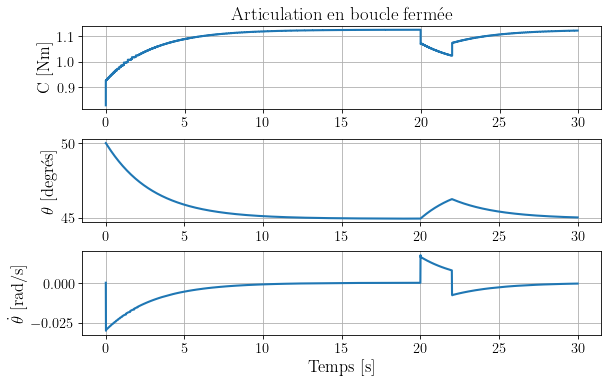

In [18]:
t_start = 0
t_end = 30
dt = 0.001

t_vec = np.linspace(t_start, t_end, int((t_end - t_start) / dt) + 1)

u_pre = 1.12
x_eq = [45 * np.pi / 180, 0]

ar_nl_bf = Articulation_BF(h, l, u_pre, x_eq)

x = [[50 * np.pi / 180], [0]]

examples.run(ar_nl_bf, t_vec, x, [0 for _ in t_vec])

fig, axs = plt.subplots(3, 1, constrained_layout=True)
axs[0].step(ar_nl_bf.tc[:-1], ar_nl_bf.u[:-1])
axs[1].plot(t_vec, np.array(x[0]) * 180 / np.pi)
axs[2].plot(t_vec, x[1])
axs[0].set_title('Articulation en boucle fermée')
axs[0].set_ylabel('C [Nm]')
axs[1].set_ylabel(r'$\theta$ [degrés]')
axs[2].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axs[2].set_xlabel('Temps [s]')
axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)